# Non-Periodic Boundary Conditions

This tutorial demonstrates how to simulate polymers with **non-periodic boundary conditions**, which are essential for modeling confined systems like thin films, surfaces, and interfaces.

**What you'll learn:**
- Reflecting (Neumann) boundary conditions: impenetrable walls
- Absorbing (Dirichlet) boundary conditions: reactive surfaces
- Mixed boundary conditions: combining different BC types
- Physical interpretation of each boundary condition

**Prerequisites:** Complete `00_QuickStart.ipynb` and `Diblock.ipynb` first.

## 1. Setup

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "1"      # Optimize threading
os.environ["MKL_NUM_THREADS"] = "1"      # Single-threaded MKL

import numpy as np
import matplotlib.pyplot as plt
from polymerfts import PropagatorSolver

print("Ready to explore non-periodic boundary conditions!")

## 2. Overview of Boundary Conditions

The standard pseudo-spectral method uses FFT, which implicitly imposes **periodic** boundary conditions. For confined systems, we need different options:

| Boundary Condition | Mathematical Form | Physical Meaning | Numerical Transform |
|-------------------|-------------------|------------------|---------------------|
| **Periodic** | $q(0) = q(L)$ | Bulk polymer (infinite system) | FFT |
| **Reflecting** (Neumann) | $\frac{\partial q}{\partial n} = 0$ | Impenetrable wall | DCT |
| **Absorbing** (Dirichlet) | $q = 0$ | Reactive/sticky surface | DST |

### Physical Intuition

**Reflecting BC:** Think of a chain hitting a hard wall — it bounces back. No polymer flux through the boundary, so **mass is conserved**. Examples: glass walls, non-reactive substrates, confinement between parallel plates.

**Absorbing BC:** Think of a chain that sticks irreversibly when it touches the surface. The propagator goes to zero at the boundary, so **mass decreases** over time. Examples: reactive surfaces, chain grafting sites, polymer degradation at interfaces.

### BC Format in PropagatorSolver

Boundary conditions are specified as a list of strings:
- **1D**: `[x_low, x_high]`
- **2D**: `[x_low, x_high, y_low, y_high]`
- **3D**: `[x_low, x_high, y_low, y_high, z_low, z_high]`

Each element can be: `"periodic"`, `"reflecting"`, or `"absorbing"`

## 3. Reflecting Boundary Conditions

**Physical interpretation:** The polymer cannot pass through the boundary — like hitting an impenetrable wall. The chain bounces back, and mass is conserved throughout the simulation.

**Mathematical condition:** $\frac{\partial q}{\partial n} = 0$ (zero flux normal to the boundary)

**Real-world examples:**
- Polymer melts confined between glass plates
- Polymer brushes on non-reactive substrates
- Block copolymer thin films with neutral walls
- Bulk simulations (periodic BC is actually a special case of reflecting for symmetric systems)

In [22]:
# Create solver with reflecting BC on both sides
N = 64
L = 4.0
ds = 0.01

solver_reflect = PropagatorSolver(
    nx=[N], lx=[L],
    bc=["reflecting", "reflecting"],  # Both walls are impenetrable
    ds=ds,
    bond_lengths={"A": 1.0}
)
solver_reflect.add_polymer(1.0, [["A", 1.0, 0, 1]])

print(solver_reflect.info)

PropagatorSolver Configuration:
  Dimensions: 1D
  Grid: [64]
  Box size: [4.0]
  Boundary conditions: ['reflecting', 'reflecting']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-mkl
  Monomer types: ['A']


In [23]:
# Zero potential (free diffusion)
w = np.zeros(N)
solver_reflect.set_fields({"A": w})

# Gaussian initial condition (off-center to see boundary effects)
dx = L / N
x = np.linspace(dx/2, L - dx/2, N)
q_init = np.exp(-((x - L/4)**2) / (2 * 0.3**2))

# Evolve and track mass
n_steps = 100
q = q_init.copy()
masses = [np.sum(q) * dx]
snapshots = [(0, q.copy())]

for step in range(n_steps):
    q = solver_reflect.advance(q, "A")
    masses.append(np.sum(q) * dx)
    if (step + 1) in [20, 50, 100]:
        snapshots.append((step + 1, q.copy()))

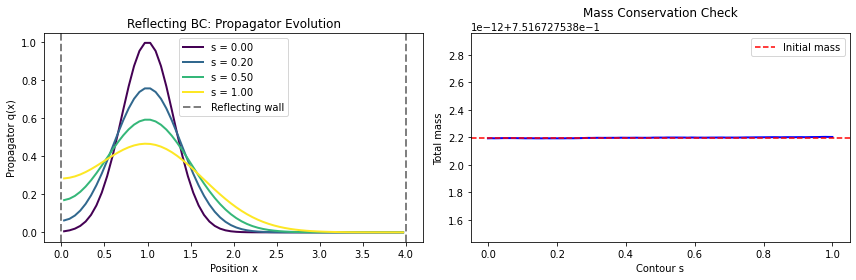


Mass conservation error: 1.31e-14
Result: Mass is CONSERVED with reflecting BC (as expected)


In [24]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Propagator evolution
colors = plt.cm.viridis(np.linspace(0, 1, len(snapshots)))
for (step, snap), color in zip(snapshots, colors):
    axes[0].plot(x, snap, color=color, linewidth=2, label=f's = {step*ds:.2f}')

axes[0].axvline(x=0, color='gray', linestyle='--', linewidth=2, label='Reflecting wall')
axes[0].axvline(x=L, color='gray', linestyle='--', linewidth=2)
axes[0].set(xlabel='Position x', ylabel='Propagator q(x)', 
            title='Reflecting BC: Propagator Evolution')
axes[0].legend()
axes[0].set_xlim(-0.2, L + 0.2)

# Right: Mass conservation
axes[1].plot(np.arange(len(masses)) * ds, masses, 'b-', linewidth=2)
axes[1].axhline(y=masses[0], color='r', linestyle='--', label='Initial mass')
axes[1].set(xlabel='Contour s', ylabel='Total mass', 
            title='Mass Conservation Check')
axes[1].legend()

plt.tight_layout()
plt.show()

mass_error = abs(masses[-1] - masses[0]) / masses[0]
print(f"\nMass conservation error: {mass_error:.2e}")
print("Result: Mass is CONSERVED with reflecting BC (as expected)")

## 4. Absorbing Boundary Conditions

**Physical interpretation:** The polymer is instantly "absorbed" or removed when any segment reaches the boundary. This models reactive or sticky surfaces where chains bind irreversibly.

**Mathematical condition:** $q = 0$ at the boundary

**Real-world examples:**
- Polymers near reactive surfaces that form covalent bonds
- First-passage time problems (how long until a chain segment reaches the surface?)
- Chain degradation or cleavage at interfaces
- Selective binding/adsorption studies

In [25]:
# Create solver with absorbing BC
solver_absorb = PropagatorSolver(
    nx=[N], lx=[L],
    bc=["absorbing", "absorbing"],  # Both walls are reactive
    ds=ds,
    bond_lengths={"A": 1.0}
)
solver_absorb.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_absorb.set_fields({"A": w})

# Same initial condition
q = q_init.copy()
masses_absorb = [np.sum(q) * dx]
snapshots_absorb = [(0, q.copy())]

for step in range(n_steps):
    q = solver_absorb.advance(q, "A")
    masses_absorb.append(np.sum(q) * dx)
    if (step + 1) in [20, 50, 100]:
        snapshots_absorb.append((step + 1, q.copy()))

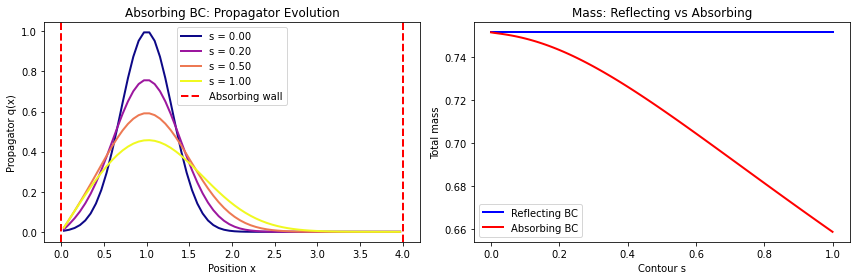


Final mass / Initial mass = 0.8762
Mass absorbed: 12.4%
Result: Mass DECREASES with absorbing BC (polymer absorbed at boundaries)


In [26]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: Propagator evolution
colors = plt.cm.plasma(np.linspace(0, 1, len(snapshots_absorb)))
for (step, snap), color in zip(snapshots_absorb, colors):
    axes[0].plot(x, snap, color=color, linewidth=2, label=f's = {step*ds:.2f}')

axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Absorbing wall')
axes[0].axvline(x=L, color='red', linestyle='--', linewidth=2)
axes[0].set(xlabel='Position x', ylabel='Propagator q(x)', 
            title='Absorbing BC: Propagator Evolution')
axes[0].legend()
axes[0].set_xlim(-0.2, L + 0.2)

# Right: Mass comparison
s_values = np.arange(len(masses)) * ds
axes[1].plot(s_values, masses, 'b-', linewidth=2, label='Reflecting BC')
axes[1].plot(s_values, masses_absorb, 'r-', linewidth=2, label='Absorbing BC')
axes[1].set(xlabel='Contour s', ylabel='Total mass', 
            title='Mass: Reflecting vs Absorbing')
axes[1].legend()

plt.tight_layout()
plt.show()

mass_ratio = masses_absorb[-1] / masses_absorb[0]
print(f"\nFinal mass / Initial mass = {mass_ratio:.4f}")
print(f"Mass absorbed: {(1 - mass_ratio) * 100:.1f}%")
print("Result: Mass DECREASES with absorbing BC (polymer absorbed at boundaries)")

## 5. Mixed Boundary Conditions (2D)

In real applications, different surfaces often have different chemical properties. **Mixed boundary conditions** let you model these asymmetric systems.

**Example: Thin film with reactive surfaces**
- **X-direction (sides):** Reflecting — impenetrable confining walls
- **Y-direction (top/bottom):** Absorbing — reactive surfaces where chains bind

This geometry models a polymer film sandwiched between two reactive surfaces, with confining side walls. Such systems are relevant to:
- Polymer adhesion studies
- Nanopore confinement with functionalized surfaces
- Block copolymer thin films with selective substrates

In [27]:
# 2D solver with mixed BC
NX, NY = 32, 24
LX, LY = 4.0, 3.0

solver_mixed = PropagatorSolver(
    nx=[NX, NY], lx=[LX, LY],
    bc=["reflecting", "reflecting",   # X: impenetrable side walls
        "absorbing", "absorbing"],    # Y: reactive top/bottom
    ds=ds,
    bond_lengths={"A": 1.0},
    platform="cpu-mkl"  # Use CPU for non-periodic BC
)
solver_mixed.add_polymer(1.0, [["A", 1.0, 0, 1]])

print(solver_mixed.info)

PropagatorSolver Configuration:
  Dimensions: 2D
  Grid: [32, 24]
  Box size: [4.0, 3.0]
  Boundary conditions: ['reflecting', 'reflecting', 'absorbing', 'absorbing']
  Chain model: continuous
  Contour step (ds): 0.01
  Method: pseudospectral
  Platform: cpu-mkl
  Monomer types: ['A']


In [28]:
# Zero potential
M = NX * NY
w_2d = np.zeros(M)
solver_mixed.set_fields({"A": w_2d})

# 2D Gaussian initial condition (centered)
dx, dy = LX/NX, LY/NY
x_2d = np.linspace(dx/2, LX - dx/2, NX)
y_2d = np.linspace(dy/2, LY - dy/2, NY)
X, Y = np.meshgrid(x_2d, y_2d, indexing='ij')

q_init_2d = np.exp(-((X - LX/2)**2 + (Y - LY/2)**2) / (2 * 0.5**2)).flatten()

# Evolve
n_steps_2d = 50
q = q_init_2d.copy()
snapshots_2d = [(0, q.copy().reshape(NX, NY))]

for step in range(n_steps_2d):
    q = solver_mixed.advance(q, "A")
    if (step + 1) in [10, 25, 50]:
        snapshots_2d.append((step + 1, q.copy().reshape(NX, NY)))

/tmp/ipykernel_672112/586732998.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


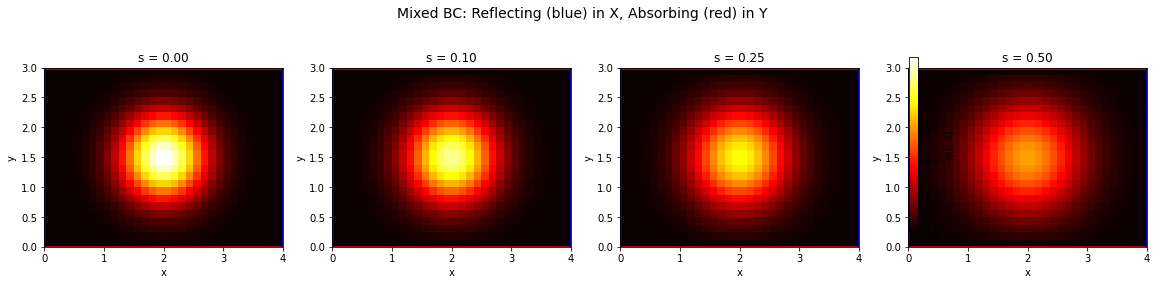


Observation:
  - The propagator spreads in X (reflecting BC preserves mass)
  - The propagator is absorbed at Y boundaries (mass decreases)
  - X-symmetry is preserved (symmetric initial condition + reflecting BC)


In [29]:
# Visualize 2D evolution
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

titles = [f's = {s*ds:.2f}' for s, _ in snapshots_2d]
vmax = np.max([np.max(snap) for _, snap in snapshots_2d])

for ax, (step, snap), title in zip(axes, snapshots_2d, titles):
    im = ax.imshow(snap.T, origin='lower', extent=[0, LX, 0, LY],
                   cmap='hot', vmin=0, vmax=vmax)
    ax.set(xlabel='x', ylabel='y', title=title)
    
    # Mark boundary types
    ax.axhline(y=0, color='red', linestyle='-', linewidth=3, alpha=0.7)
    ax.axhline(y=LY, color='red', linestyle='-', linewidth=3, alpha=0.7)
    ax.axvline(x=0, color='blue', linestyle='-', linewidth=3, alpha=0.7)
    ax.axvline(x=LX, color='blue', linestyle='-', linewidth=3, alpha=0.7)

plt.suptitle('Mixed BC: Reflecting (blue) in X, Absorbing (red) in Y', fontsize=14)
fig.colorbar(im, ax=axes.ravel().tolist(), label='q(r, s)', shrink=0.8)
plt.tight_layout()
plt.show()

print("\nObservation:")
print("  - The propagator spreads in X (reflecting BC preserves mass)")
print("  - The propagator is absorbed at Y boundaries (mass decreases)")
print("  - X-symmetry is preserved (symmetric initial condition + reflecting BC)")

## 6. Comparison of Numerical Methods

For non-periodic boundary conditions, two numerical methods are available:

| Method | Transform | Accuracy | Speed | Best For |
|--------|-----------|----------|-------|----------|
| **Pseudo-spectral** | DCT/DST | Spectral (exponential) | Fast | Smooth solutions, high accuracy |
| **Real-space** | Finite diff | 2nd order | Moderate | Complex BCs, robustness |

**Pseudo-spectral (DCT/DST):** Converts boundary conditions to spectral space using discrete cosine/sine transforms. Achieves exponential convergence for smooth solutions — adding more grid points rapidly improves accuracy.

**Real-space (Crank-Nicolson):** Uses finite differences with alternating direction implicit (ADI) splitting. More robust for sharp features but only 2nd-order accurate.

Both methods converge to the same solution as grid resolution increases:

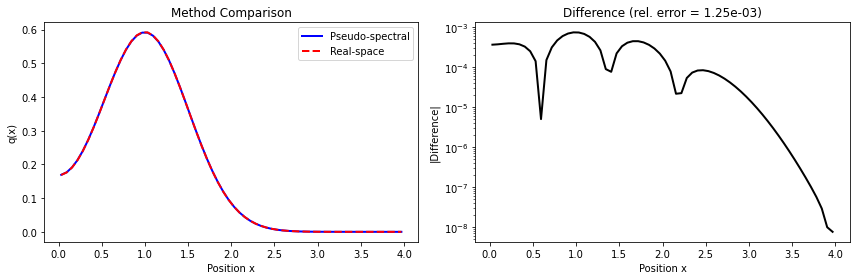


Methods agree within 0.125% relative error


In [30]:
# Compare pseudo-spectral and real-space methods
bc = ["reflecting", "absorbing"]  # Mixed 1D BC

# Pseudo-spectral solver
solver_ps = PropagatorSolver(
    nx=[N], lx=[L], bc=bc, ds=ds,
    method="pseudospectral"
)
solver_ps.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_ps.set_fields({"A": np.zeros(N)})

# Real-space solver  
solver_rs = PropagatorSolver(
    nx=[N], lx=[L], bc=bc, ds=ds,
    method="realspace"
)
solver_rs.add_polymer(1.0, [["A", 1.0, 0, 1]])
solver_rs.set_fields({"A": np.zeros(N)})

# Evolve both
q_ps = q_init.copy()
q_rs = q_init.copy()

for _ in range(50):
    q_ps = solver_ps.advance(q_ps, "A")
    q_rs = solver_rs.advance(q_rs, "A")

# Compare
max_diff = np.max(np.abs(q_ps - q_rs))
rel_err = max_diff / np.max(np.abs(q_ps))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, q_ps, 'b-', linewidth=2, label='Pseudo-spectral')
axes[0].plot(x, q_rs, 'r--', linewidth=2, label='Real-space')
axes[0].set(xlabel='Position x', ylabel='q(x)', title='Method Comparison')
axes[0].legend()

axes[1].semilogy(x, np.abs(q_ps - q_rs), 'k-', linewidth=2)
axes[1].set(xlabel='Position x', ylabel='|Difference|', 
            title=f'Difference (rel. error = {rel_err:.2e})')

plt.tight_layout()
plt.show()

print(f"\nMethods agree within {rel_err*100:.3f}% relative error")

## 7. Summary

### Key Physical Concepts

1. **Reflecting BC** (`"reflecting"`): 
   - Impenetrable wall — chain bounces back
   - Zero flux at boundary ($\partial q/\partial n = 0$)
   - **Mass is conserved** throughout propagation
   - Uses Discrete Cosine Transform (DCT)

2. **Absorbing BC** (`"absorbing"`): 
   - Reactive surface — chain is removed on contact
   - Zero value at boundary ($q = 0$)
   - **Mass decreases** as chains are absorbed
   - Uses Discrete Sine Transform (DST)

3. **Mixed BC**: Combine different BC types on different boundaries to model realistic asymmetric systems

### Practical Notes

- **Two methods available**: 
  - `method="pseudospectral"` (default): Higher accuracy, uses DCT/DST
  - `method="realspace"`: More flexible, uses finite differences

- **Platform compatibility**:
  - **CPU-MKL**: Supports both methods for all BC types
  - **CUDA**: Auto-switches to `realspace` for non-periodic BC (DCT/DST not available in cuFFT)

### Next Steps

- **Grafting polymers to surfaces**: See `GraftingPoints.ipynb`
- **Polymers around particles**: See `NanoParticle.ipynb`
- **Self-consistent field theory**: See `../SelfConsistentFieldTheory/`